In [10]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from mpl_toolkits.mplot3d import axes3d

In [55]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [59]:
N_HANDS_TO_PLAY= 5*10**6


nStates       = np.prod([21-12+1,13,2])
posHandSums   = range(12,22) 
nActions      = 2  # 0=>stick; 1=>hit 
Q             = np.zeros((nStates,nActions))  # the initial action-value function
#pol_pi        = np.zeros((1,nStates));         # our initial policy is to always stick "0"
pol_pi        = np.ones(nStates)        # our initial policy is to always hit "1"
#pol_pi        = np.random.randint(0,2,nStates)   # our initial policy is random 
firstSARewSum = np.zeros((nStates,nActions))
firstSARewCnt = np.zeros((nStates,nActions)) 


for _ in xrange(N_HANDS_TO_PLAY):  
    stateseen = [] 
    deck = shufflecards()
    # the player gets the first two cards: 
    p = deck[:2]
    deck = deck[2:]
    phv = handValue(p)[0]
    # the dealer gets the next two cards (and shows his first card): 
    d = deck[:2]
    deck = deck[2:]
    dhv = handValue(d)[0]
    cardShowing = d[0] 
  
    # disgard states who's initial sum is less than 12 (the decision is always to hit): 
    while phv < 12: 
        p = np.hstack((p, deck[0]))
        deck = deck[1:]
        phv = handValue(p)[0] # HIT

  
    # accumulate/store the first state seen: 
    stateseen.append(stateFromHand(p, cardShowing ))
    
    # implement the policy specified by pol_pi (keep hitting till we should "stick"):
    si = 0 
    polInd = np.ravel_multi_index((stateseen[si][0]-12, stateseen[si][1]-1, stateseen[si][2]), 
                                  [21-12+1,13,2])
    pol_pi[polInd] = np.random.choice((0,1))      # FOR EXPLORING STARTS TAKE AN INITIAL RANDOM POLICY!!! 
    pol_to_take    = pol_pi[polInd]
    
    while pol_to_take and phv < 22: 
        p = np.hstack((p, deck[0]))
        deck = deck[1:]
        phv = handValue(p)[0] # HIT
        stateseen.append(stateFromHand(p, cardShowing))
        if phv <= 21: #only then do we need to querry the next policy action when we have not gone bust
            si = si+1 
            polInd = np.ravel_multi_index( (stateseen[si][0]-12, stateseen[si][1]-1, stateseen[si][2]), 
                                          [21-12+1,13,2]); 
            pol_to_take = pol_pi[polInd]
    
    # implement the fixed deterministic policy of the dealer (hit until we have a hand value of 17): 
    while dhv < 17:
        d = np.hstack((d, deck[0]))
        deck = deck[1:]
        dhv = handValue(d)[0] #HIT
  
    # determine the reward for playing this game:
    rew = determineReward(phv,dhv);
  
  
    # accumulate these values used in computing statistics on this action value function Q^{\pi}: 
    for si in range(len(stateseen)):
        if ( stateseen[si][0]>=12) and (stateseen[si][0] <=21): # we don't count "initial" and terminal states

            staInd = np.ravel_multi_index((stateseen[si][0]-12, stateseen[si][1]-1, stateseen[si][2]), 
                                          [21-12+1,13,2])
            actInd = pol_pi[staInd] 
            firstSARewCnt[staInd,actInd] = firstSARewCnt[staInd,actInd]+1; 
            firstSARewSum[staInd,actInd] = firstSARewSum[staInd,actInd]+rew; 
            Q[staInd,actInd]             = firstSARewSum[staInd,actInd]/firstSARewCnt[staInd,actInd] 
            greedyChoice                 = np.argmax(Q[staInd,:])
            pol_pi[staInd]               = greedyChoice

# plot the optimal state-value function V^{*}: 

mc_value_fn = np.max( Q, axis=1 )
mc_value_fn = np.reshape( mc_value_fn, [21-12+1,13,2])


In [53]:
from IPython.core.pylabtools import figsize

<matplotlib.colorbar.Colorbar instance at 0x7fe898613b00>

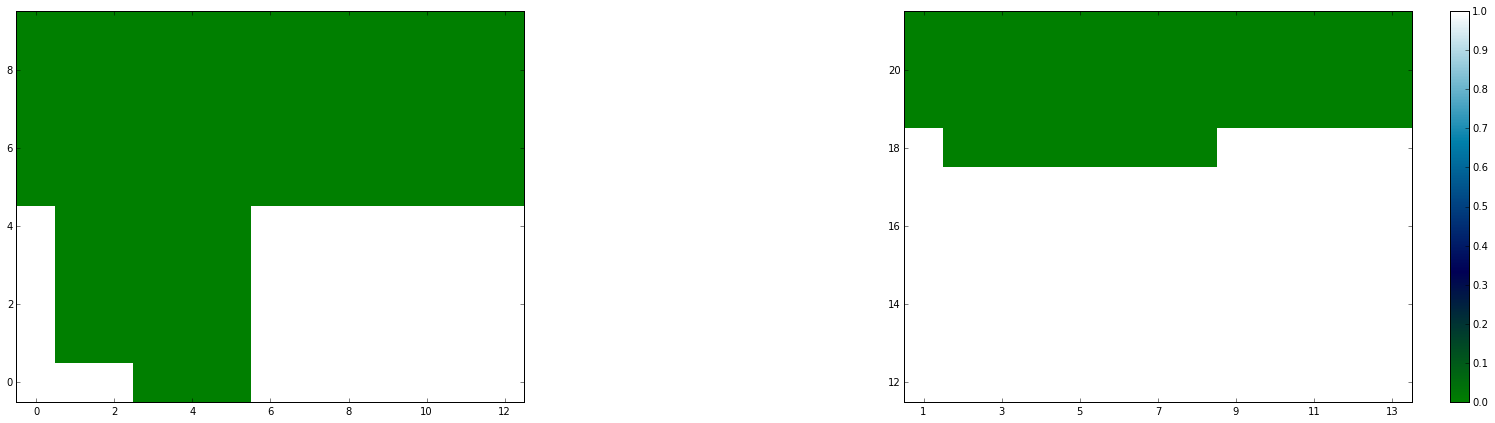

In [91]:
figsize(30,7)

Z = pol_pi.reshape((10,13,2))

fig = plt.figure()
ax = fig.add_subplot(1,2,1)
ax.set_aspect('equal')
plt.imshow(Z[:,:,0], interpolation='nearest', cmap=plt.cm.ocean, origin='left')

ax = fig.add_subplot(1,2,2)
ax.set_aspect('equal')
plt.imshow(Z[:,:,1], interpolation='nearest', cmap=plt.cm.ocean, origin='left')
ax.set_xticklabels(range(-1, 15, 2))
ax.set_yticklabels(map(str, range(10,22,2)))
plt.colorbar()
 

No usable ace


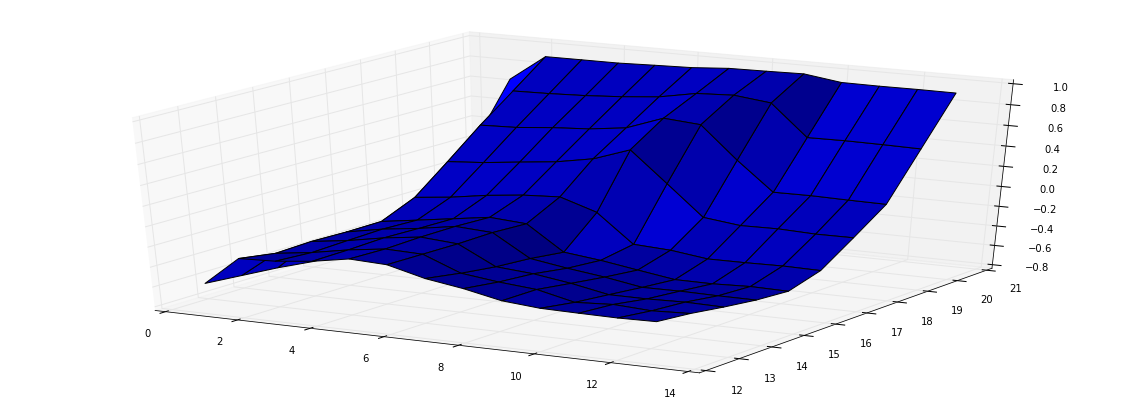

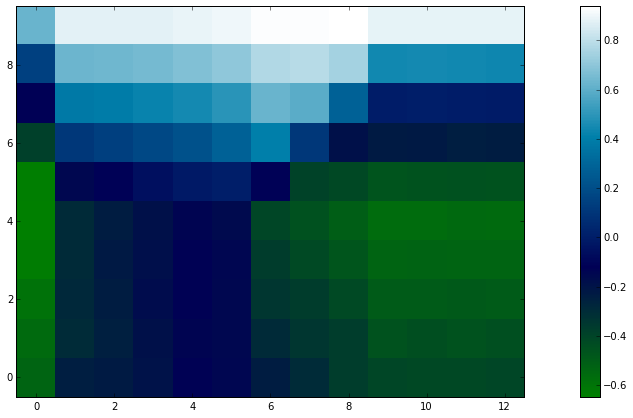

Usable ace


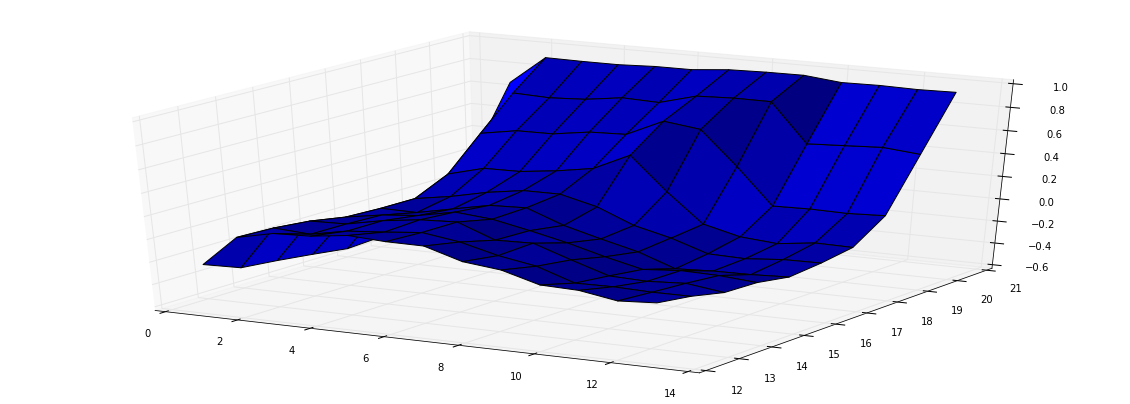

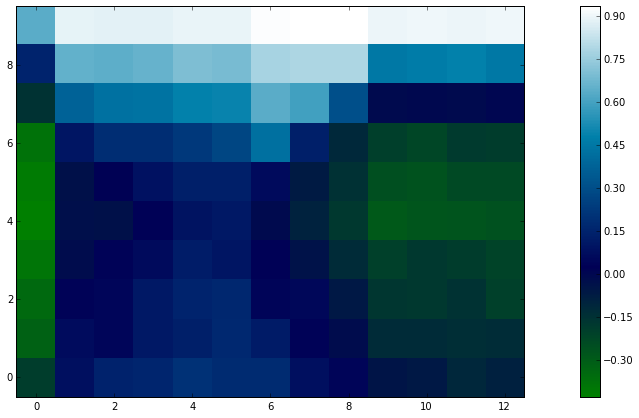

In [63]:
print 'No usable ace'
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X = np.tile(np.arange(1,14), (10,1))
Y = np.repeat(np.arange(12, 22).reshape(10,1),13, axis=1) 

Z = mc_value_fn[:,:,0]
ax.plot_surface(X, Y, Z, rstride=1, cstride=1)
figsize(20,7)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plt.imshow(Z, interpolation='nearest', cmap=plt.cm.ocean, origin='left')
plt.colorbar()
plt.show()  

print 'Usable ace'
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X = np.tile(np.arange(1,14), (10,1))
Y = np.repeat(np.arange(12, 22).reshape(10,1),13, axis=1) 

Z = mc_value_fn[:,:,1]
ax.plot_surface(X, Y, Z, rstride=1, cstride=1)
figsize(20,7)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plt.imshow(Z, interpolation='nearest', cmap=plt.cm.ocean, origin='left')
plt.colorbar()
plt.show()  
#fn=sprintf('state_value_fn_nua_%d_mesh.eps',N_HANDS_TO_PLAY); saveas( gcf, fn, 'eps2' );

In [11]:
def determineReward(phv,dhv):
    if phv > 21: # player went bust
        rew = -1 
    elif dhv > 21: # dealer went bust
        rew = +1 
    elif phv == dhv: # a tie
      rew = 0 
    elif phv > dhv: # the larger hand wins
      rew = +1 
    else:
      rew = -1
    return rew


In [12]:
def shufflecards():
    deck = np.random.permutation(range(1,53))
    return deck

In [13]:
def handValue(hand):
    # compute 1:13 indexing for each card: 
    values = [np.mod(h - 1, 13 )+1 for h in hand] 
    # map face cards (11,12,13)'s to 10's:
    values = np.minimum(values, 10)
    sv     = sum(values) 
    # Promote soft ace
    if (np.any(values==1)) and (sv<=11):
        sv = sv + 10
        usableAce = 1 
    else:
        usableAce = 0
    hv = sv 
    return hv, usableAce

In [14]:
def stateFromHand(hand,cardShowing):
#     %
#     % Returns the state (a three vector of numbers for a given hand of cards)
#     % 
#     % [players current sum, dealar showing card, usable ace] 
#     % 
#     % Cards are enoumerated 1:52, such that
#     % 
#     %  1:13 => A, 2, 3, ..., 10, J, Q, K      (of C)
#     % 14:26                                   (of D)
#     %                                         (of H)
#     %                                         (of S)
#     %


    [hv,usableAce] = handValue(hand)
    cardShowing = np.mod(cardShowing - 1, 13) + 1
    st = [hv, cardShowing, usableAce] 
    return st 



